In [1]:
import os
import os.path as osp
import sys
sys.path.insert(0, osp.dirname(osp.abspath('.')))

In [2]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn.functional as F
from  torch.utils.data import DataLoader
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from data.sampler import BalancedBatchSampler

from model.facenet import FaceNet
from model.example import ExampleNet

## Hyperparameter

In [3]:
torch.manual_seed(0)
np.random.seed(0)

In [4]:
DEVICE = "cuda:1"
IMG_SIZE = 112
DATASET_ROOT = "../download/train/CASIA-WebFace/"
LABEL_TO_INDICES_PATH = "../download/processed/label_to_indices.pth"
P = 4
K = 64
FACENET_CHECKPOINT_PATH = "../run/facenet/best.pth"
EXAMPLE_CHECKPOINT_PATH = "../run/example/best.pth"

## Dataset

In [5]:
inverse = T.Compose([
    T.Normalize(mean=[0., 0., 0.],
                std=[1/0.229, 1/0.224, 1/0.225]),
    T.Normalize(mean=[-0.485, -0.456, -0.406],
                std=[1., 1., 1.]),
    T.ToPILImage()
])
transform = T.Compose([
                T.Resize(IMG_SIZE),
                T.RandomHorizontalFlip(),
                T.ToTensor(),
                T.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
                ])
dataset = ImageFolder(root=DATASET_ROOT, transform=transform)

In [6]:
labels = [ s[1] for s in dataset.samples ]
label_to_indices = torch.load(LABEL_TO_INDICES_PATH)
sampler = BalancedBatchSampler(labels, P=P, K=K, label_to_indices=label_to_indices)

In [7]:
dataloader = DataLoader(dataset=dataset, batch_sampler=sampler)

In [8]:
imgs, labels = next(iter(dataloader))
imgs = imgs.to(DEVICE)
labels = labels.to(DEVICE)

## FaceNet

In [10]:
facenet = FaceNet(3, 128)
checkpoint = torch.load(FACENET_CHECKPOINT_PATH)
facenet.load_state_dict(checkpoint['model'])
facenet = facenet.to(DEVICE)
facenet = facenet.eval()

In [11]:
checkpoint['current_acc']

0.8955714285714287

In [12]:
embeds = facenet(imgs)

# Perform dimension reduction
reduced = embeds.detach().cpu().numpy()
pca = PCA(n_components=2)
reduced = pca.fit_transform(reduced)
reduced = torch.tensor(reduced)

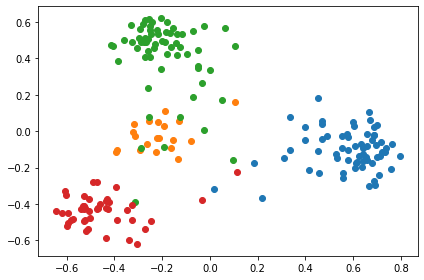

In [13]:
classes = list(set(labels.detach().cpu().numpy().tolist()))
for c in classes:
    selects = reduced[(labels == c).detach().cpu()].numpy()
    plt.scatter(selects[..., 0], selects[..., 1])
plt.tight_layout()

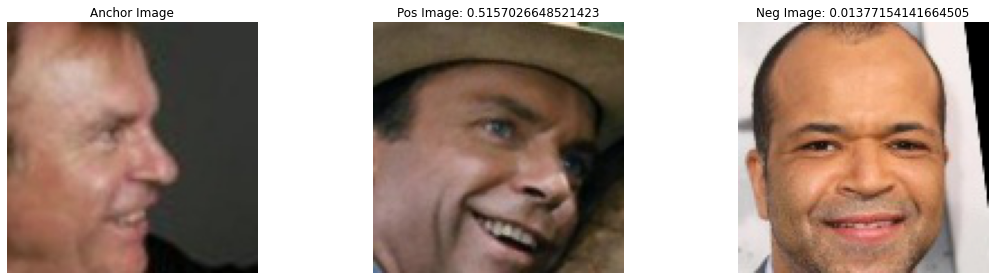

In [14]:
anchor_img = imgs[2]
pos_img = imgs[6]
neg_img = imgs[65]

anchor_embed = facenet(anchor_img.unsqueeze(0))[0].detach().cpu().numpy()
pos_embed = facenet(pos_img.unsqueeze(0))[0].detach().cpu().numpy()
neg_embed = facenet(neg_img.unsqueeze(0))[0].detach().cpu().numpy()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
axes[0].imshow(np.array(inverse(anchor_img.detach().cpu())))
axes[0].set_axis_off()
axes[0].set_title("Anchor Image")
axes[1].imshow(np.array(inverse(pos_img.detach().cpu())))
axes[1].set_axis_off()
axes[1].set_title(f"Pos Image: {np.dot(anchor_embed, pos_embed.T)}")
axes[2].imshow(np.array(inverse(neg_img.detach().cpu())))
axes[2].set_axis_off()
axes[2].set_title(f"Neg Image: {np.dot(anchor_embed, neg_embed.T)}")

plt.tight_layout()

## ExampleNet

In [15]:
net = ExampleNet(256, 10575)
checkpoint = torch.load(EXAMPLE_CHECKPOINT_PATH)
net.load_state_dict(checkpoint['model'])
net = net.to(DEVICE)
net = net.eval()

In [16]:
checkpoint['current_acc']

0.8712857142857142

In [17]:
embeds, _ = net(imgs)
enbeds = F.normalize(embeds, p=2, dim=1)

# Perform dimension reduction
reduced = embeds.detach().cpu().numpy()
pca = PCA(n_components=2)
reduced = pca.fit_transform(reduced)
reduced = torch.tensor(reduced)

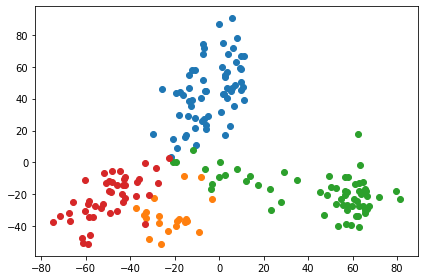

In [18]:
classes = list(set(labels.detach().cpu().numpy().tolist()))
for c in classes:
    selects = reduced[(labels == c).detach().cpu()].numpy()
    plt.scatter(selects[..., 0], selects[..., 1])
plt.tight_layout()

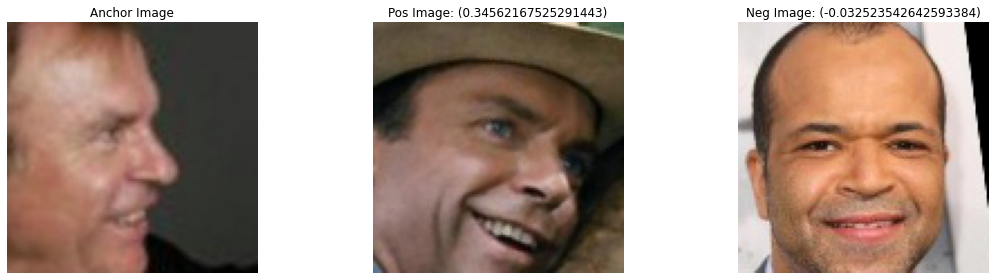

In [19]:
anchor_img = imgs[2]
pos_img = imgs[6]
neg_img = imgs[65]

anchor_embed = F.normalize(net(anchor_img.unsqueeze(0))[0], p=2, dim=1)[0].detach().cpu().numpy()
pos_embed = F.normalize(net(pos_img.unsqueeze(0))[0], p=2, dim=1)[0].detach().cpu().numpy()
neg_embed = F.normalize(net(neg_img.unsqueeze(0))[0], p=2, dim=1)[0].detach().cpu().numpy()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
axes[0].imshow(np.array(inverse(anchor_img.detach().cpu())))
axes[0].set_axis_off()
axes[0].set_title("Anchor Image")
axes[1].imshow(np.array(inverse(pos_img.detach().cpu())))
axes[1].set_axis_off()
axes[1].set_title(f"Pos Image: ({np.dot(anchor_embed, pos_embed.T)})")
axes[2].imshow(np.array(inverse(neg_img.detach().cpu())))
axes[2].set_axis_off()
axes[2].set_title(f"Neg Image: ({np.dot(anchor_embed, neg_embed.T)})")

plt.tight_layout()